# Laboratorium 2 - Zadanie 2 - walka i przygotowania

## Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Przygotowanie i wczytanie danych

In [2]:
# Przygotowanie danych
data = pd.DataFrame({
    'group': range(1, 11),
    'total': [1000, 1500, 900, 800, 1000, 800, 400, 200, 100, 400],
    'age_range': ['19-22', '23-26', '27-30', '31-34', '35-38', '39-42', '43-46', '47-50', '51-54', '55-58'],
    'work_experience': [1, 3, 5, 7, 9, 20, 20, 25, 28, 27],
    'found_job': [100, 160, 110, 130, 180, 200, 110, 60, 33, 13]
})

# Obliczenie średniego wieku i prawdopodobieństwa sukcesu
data['age_mean'] = data['age_range'].apply(lambda x: np.mean([int(i) for i in x.split('-')]))
data['success_prob'] = data['found_job'] / data['total']
data['logit'] = np.log(data['success_prob'] / (1 - data['success_prob']))

### Potencjalne nowe zmienne do modelu polinomialnego - wielomianowego

In [3]:
# Dodanie potencjalnych nowych zmiennych
data['age_squared'] = data['age_mean'] ** 2
data['exp_squared'] = data['work_experience'] ** 2
data['age_exp_interaction'] = data['age_mean'] * data['work_experience']

In [4]:
# Wybór zmiennych do analizy korelacji
features = ['age_mean', 'work_experience', 'age_squared', 'exp_squared', 'age_exp_interaction']
target = 'success_prob'

# Macierz korelacji
correlation_matrix = data[features + [target]].corr()

# Analiza VIF
X = data[features]
vif_data = pd.DataFrame()
vif_data["Variable"] = features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


print(f"VIF przed skalowaniem: \n")
print(vif_data)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
vif_data_scaled = pd.DataFrame()
vif_data_scaled["Variable"] = features
vif_data_scaled["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(f"VIF po skalowaniu: \n")
print(vif_data_scaled)


# Wizualizacja
plt.figure(figsize=(15, 12))
plt.tight_layout()
plt.show()

VIF przed skalowaniem: 

              Variable           VIF
0             age_mean   1223.324947
1      work_experience   1006.570307
2          age_squared   5967.353403
3          exp_squared   3300.827016
4  age_exp_interaction  16767.416471
VIF po skalowaniu: 

              Variable           VIF
0             age_mean   6742.022229
1      work_experience   6551.359095
2          age_squared  21380.364988
3          exp_squared   5588.152219
4  age_exp_interaction  47116.077084


<Figure size 1500x1200 with 0 Axes>

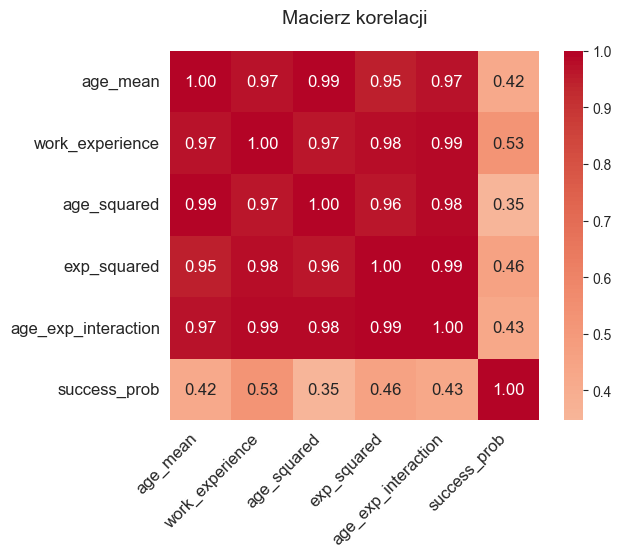

<Figure size 1200x1000 with 0 Axes>

In [5]:
# 1. Mapa ciepła korelacji
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            annot_kws={'size': 12},
            fmt='.2f',
            square=True)
# Dostosowanie etykiet
plt.xticks(rotation=45, ha='right', fontsize=12)  # rotacja i rozmiar etykiet osi X
plt.yticks(rotation=0, fontsize=12)  # rozmiar etykiet osi Y

# Tytuł
plt.title('Macierz korelacji', pad=20, fontsize=14)  # zwiększamy rozmiar tytułu i dodajemy padding


plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.show()

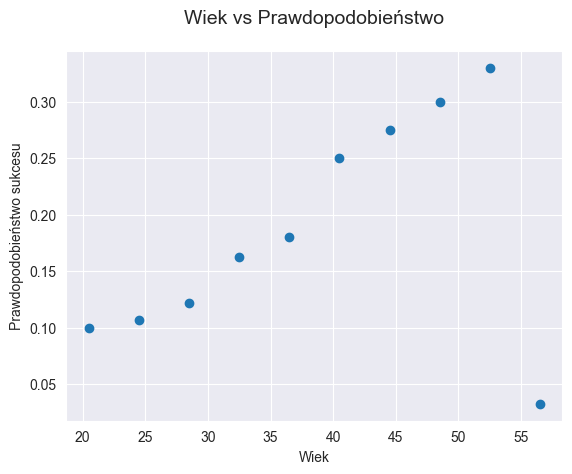

<Figure size 1200x1000 with 0 Axes>

In [6]:
# 2. Scatter plot dla wieku
plt.scatter(data['age_mean'], data['success_prob'])
plt.xlabel('Wiek')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Wiek vs Prawdopodobieństwo', pad=20, fontsize=14)

plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.show()

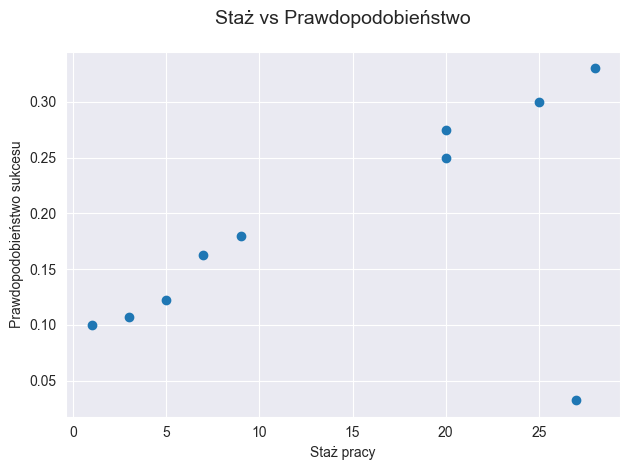

In [7]:
# 3. Scatter plot dla doświadczenia
plt.scatter(data['work_experience'], data['success_prob'])
plt.xlabel('Staż pracy')
plt.ylabel('Prawdopodobieństwo sukcesu')
plt.title('Staż vs Prawdopodobieństwo', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

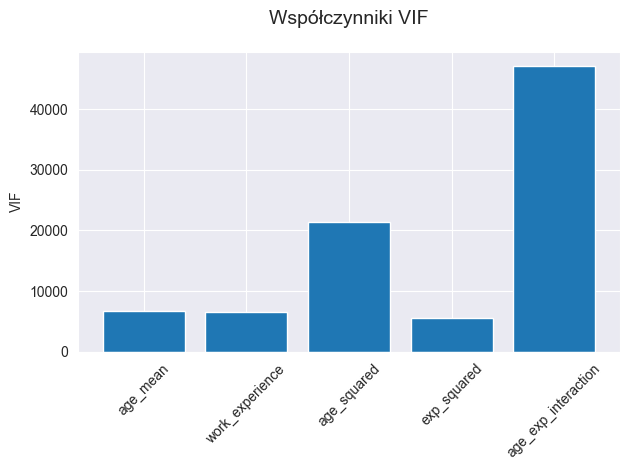

In [8]:
# 4. VIF jako wykres słupkowy dla skalowanych danych
plt.bar(vif_data['Variable'], vif_data_scaled['VIF'])
plt.xticks(rotation=45)
plt.ylabel('VIF')
plt.title('Współczynniki VIF', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


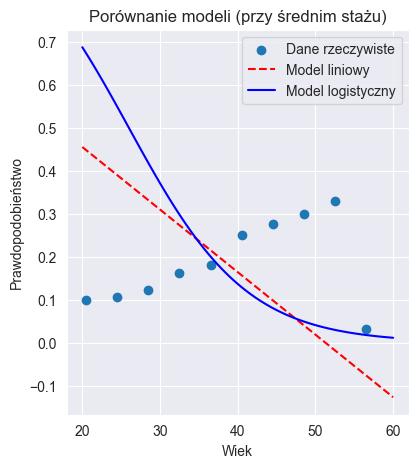

In [9]:
# Modele na podstawowych zmiennych
X_base = data[['age_mean', 'work_experience']]

# Model liniowy
linear_model = LinearRegression()
linear_model.fit(X_base, data['success_prob'])

# Model logistyczny (na transformowanych danych)
logit_model = LinearRegression()
logit_model.fit(X_base, data['logit'])

# Wizualizacja modeli
plt.figure(figsize=(15, 5))

# 1. Porównanie modeli przy średnim stażu
mean_exp = data['work_experience'].mean()
X_age = np.linspace(20, 60, 100)
X_pred = np.column_stack([X_age, np.full_like(X_age, mean_exp)])

plt.subplot(131)
plt.scatter(data['age_mean'], data['success_prob'], label='Dane rzeczywiste')
plt.plot(X_age, linear_model.predict(X_pred), 'r--', label='Model liniowy')
plt.plot(X_age, expit(logit_model.predict(X_pred)), 'b-', label='Model logistyczny')
plt.xlabel('Wiek')
plt.ylabel('Prawdopodobieństwo')
plt.title('Porównanie modeli (przy średnim stażu)')
plt.legend()

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


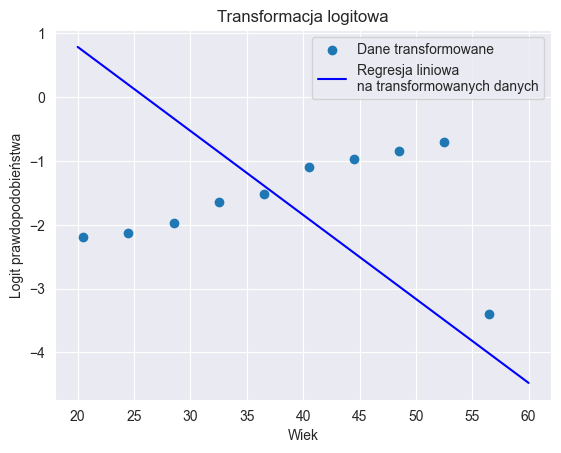

In [10]:
# 2. Transformacja logitowa

plt.scatter(data['age_mean'], data['logit'], label='Dane transformowane')
plt.plot(X_age, logit_model.predict(X_pred), 'b-', label='Regresja liniowa\nna transformowanych danych')
plt.xlabel('Wiek')
plt.ylabel('Logit prawdopodobieństwa')
plt.title('Transformacja logitowa')
plt.legend()

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


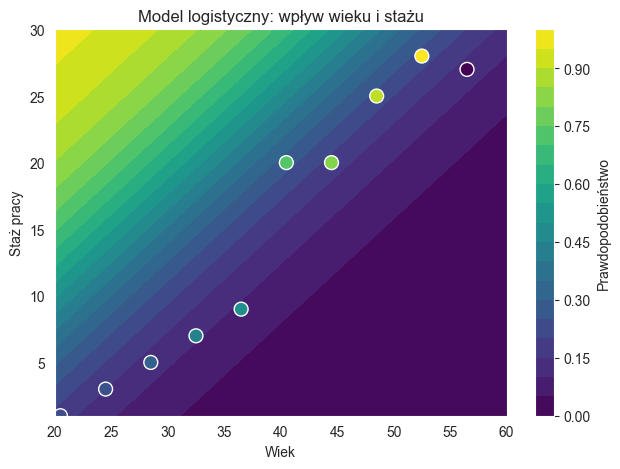

In [11]:
# 3. Mapa ciepła dla modelu logistycznego
age_grid, exp_grid = np.meshgrid(np.linspace(20, 60, 50), np.linspace(1, 30, 50))
X_grid = np.column_stack([age_grid.ravel(), exp_grid.ravel()])
Z = expit(logit_model.predict(X_grid)).reshape(age_grid.shape)

plt.contourf(age_grid, exp_grid, Z, levels=20, cmap='viridis')
plt.colorbar(label='Prawdopodobieństwo')
plt.scatter(data['age_mean'], data['work_experience'], c=data['success_prob'],
           cmap='viridis', s=100, edgecolor='white')
plt.xlabel('Wiek')
plt.ylabel('Staż pracy')
plt.title('Model logistyczny: wpływ wieku i stażu')

plt.tight_layout()
plt.show()

In [12]:
# Wyniki analizy
print("\nWspółczynniki modelu liniowego:")
print(f"Wyraz wolny: {linear_model.intercept_:.4f}")
print(f"Wiek: {linear_model.coef_[0]:.4f}")
print(f"Staż: {linear_model.coef_[1]:.4f}")

print("\nWspółczynniki modelu logistycznego (na skali logit):")
print(f"Wyraz wolny: {logit_model.intercept_:.4f}")
print(f"Wiek: {logit_model.coef_[0]:.4f}")
print(f"Staż: {logit_model.coef_[1]:.4f}")

print("\nWspółczynniki VIF:")
print(vif_data)

print("\nKorelacje z prawdopodobieństwem sukcesu:")
for feature in features:
    correlation = correlation_matrix.loc[feature, target]
    print(f"{feature}: {correlation:.3f}")
    


Współczynniki modelu liniowego:
Wyraz wolny: 0.4388
Wiek: -0.0146
Staż: 0.0212

Współczynniki modelu logistycznego (na skali logit):
Wyraz wolny: 0.9808
Wiek: -0.1316
Staż: 0.1683

Współczynniki VIF:
              Variable           VIF
0             age_mean   1223.324947
1      work_experience   1006.570307
2          age_squared   5967.353403
3          exp_squared   3300.827016
4  age_exp_interaction  16767.416471

Korelacje z prawdopodobieństwem sukcesu:
age_mean: 0.419
work_experience: 0.529
age_squared: 0.347
exp_squared: 0.461
age_exp_interaction: 0.429


Optimization terminated successfully.
         Current function value: 0.330785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           success_prob   No. Observations:                   10
Model:                          Logit   Df Residuals:                        7
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                     inf
Time:                        21:39:02   Log-Likelihood:                -3.3078
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1687      7.120      0.024      0.981     -13.786      14.124
age_mean      

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:4469: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


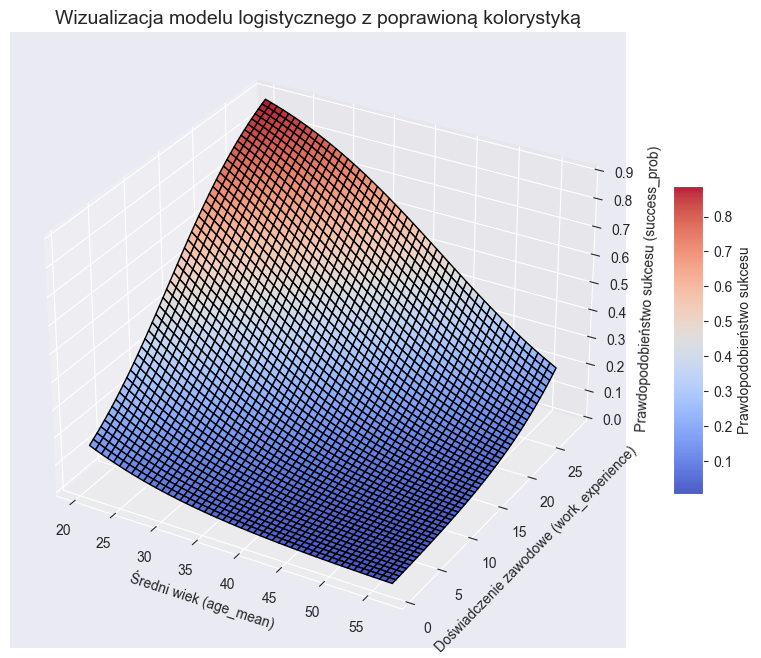

In [13]:
import statsmodels.api as sm

# %matplotlib notebook
# Przygotowanie danych do modelu (X - zmienne niezależne, y - zmienna zależna)
X = data[['age_mean', 'work_experience']]
X = sm.add_constant(X)  # Dodanie stałej (odpowiada za Beta0)
y = data['success_prob']

# Dopasowanie modelu logistycznego (funkcja logit)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Wyświetlenie wyników modelu
print(result.summary())

# Przygotowanie siatki do wizualizacji
age_range = np.linspace(data['age_mean'].min(), data['age_mean'].max(), 50)
work_exp_range = np.linspace(data['work_experience'].min(), data['work_experience'].max(), 50)
age_grid, work_exp_grid = np.meshgrid(age_range, work_exp_range)

# Obliczanie przewidywań na siatce
X_grid = sm.add_constant(np.c_[age_grid.ravel(), work_exp_grid.ravel()])
y_grid_pred = result.predict(X_grid).reshape(age_grid.shape)

# # Wizualizacja 3D biala
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(age_grid, work_exp_grid, y_grid_pred, cmap='viridis', alpha=0.8)
# 
# # Oznaczenia osi
# ax.set_title("Wizualizacja modelu logistycznego")
# ax.set_xlabel("Średni wiek (age_mean)")
# ax.set_ylabel("Doświadczenie zawodowe (work_experience)")
# ax.set_zlabel("Prawdopodobieństwo sukcesu (success_prob)")
# plt.show()

# Wizualizacja 3D z poprawioną kolorystyką czarna
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Rysowanie powierzchni z lepszym kontrastem kolorów
surf = ax.plot_surface(age_grid, work_exp_grid, y_grid_pred, cmap='coolwarm', edgecolor='k', alpha=0.9)

# Dodanie paska kolorów (legendy)
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Prawdopodobieństwo sukcesu")

# Ustawienia osi i tytułu
ax.set_title("Wizualizacja modelu logistycznego z poprawioną kolorystyką", fontsize=14)
ax.set_xlabel("Średni wiek (age_mean)", fontsize=10)
ax.set_ylabel("Doświadczenie zawodowe (work_experience)", fontsize=10)
ax.set_zlabel("Prawdopodobieństwo sukcesu (success_prob)", fontsize=10)

# Dostosowanie widoczności siatki
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.show()


## Nowe podejscie

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns

In [15]:

# Create the dataset
data = {
    'group': range(1, 11),
    'n_unemployed': [1000, 1500, 900, 800, 1000, 800, 400, 200, 100, 400],
    'age_range': ['19-22', '23-26', '27-30', '31-34', '35-38', '39-42', '43-46', '47-50', '51-54', '55-58'],
    'work_experience': [1, 3, 5, 7, 9, 20, 20, 25, 28, 27],
    'found_job': [100, 160, 110, 130, 180, 200, 110, 60, 33, 13]
}

df = pd.DataFrame(data)

# Calculate average age for each group
df['age_avg'] = df['age_range'].apply(lambda x: np.mean([int(i) for i in x.split('-')]))

# Calculate success probability
df['success_prob'] = df['found_job'] / df['n_unemployed']

# Calculate logit transformation (log-odds)
# Add small epsilon to avoid log(0) and log(1)
epsilon = 1e-10
df['logit'] = np.log((df['success_prob'] + epsilon) / (1 - df['success_prob'] + epsilon))

# Prepare features
X = df[['age_avg', 'work_experience']]
y = df['success_prob']
y_logit = df['logit']

In [16]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [17]:
# Fit three different models
# 1. Standard Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)
y_pred_lin = lin_reg.predict(X_scaled)

# 2. Polynomial Regression
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)

# 3. Logit Transformation with Linear Regression
logit_reg = LinearRegression()
logit_reg.fit(X_scaled, y_logit)
y_pred_logit = 1 / (1 + np.exp(-logit_reg.predict(X_scaled)))

In [18]:
# Calculate R-squared for all models
r2_lin = r2_score(y, y_pred_lin)
r2_poly = r2_score(y, y_pred_poly)
r2_logit = r2_score(y, y_pred_logit)

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


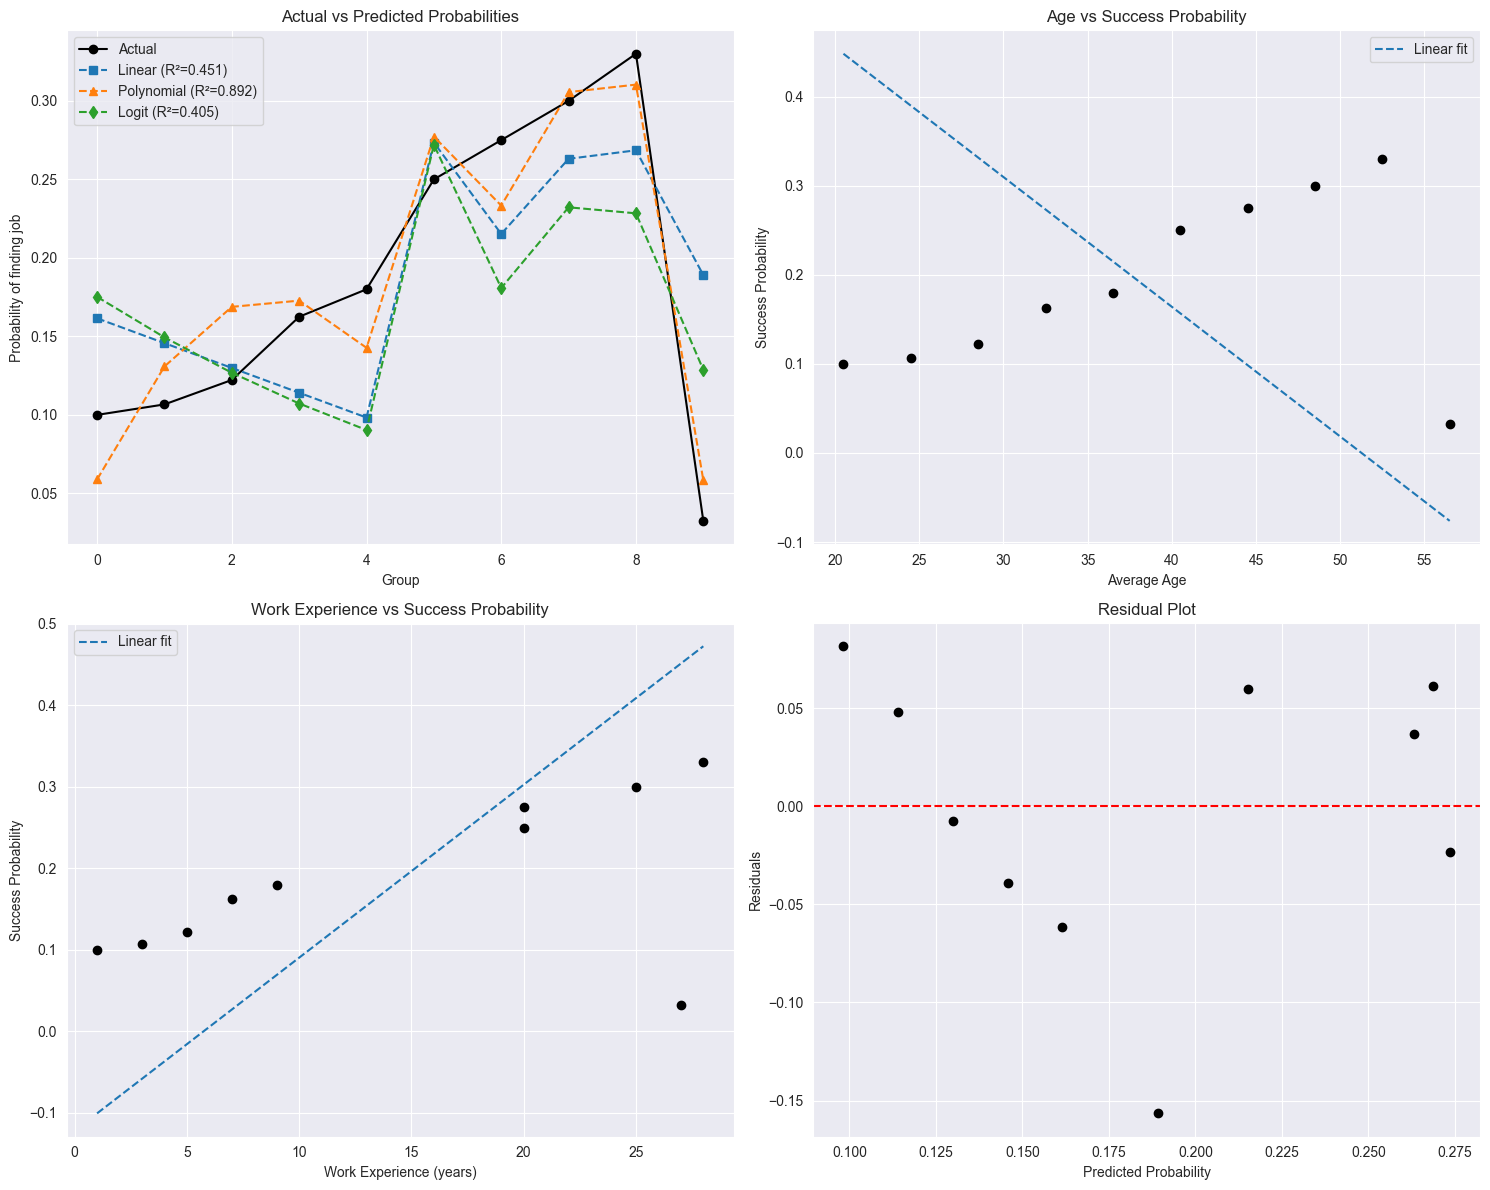

In [19]:
# Create visualizations
plt.figure(figsize=(15, 12))

# Plot 1: Actual vs Predicted probabilities
plt.subplot(2, 2, 1)
plt.plot(range(len(y)), y, 'o-', label='Actual', color='black')
plt.plot(range(len(y)), y_pred_lin, 's--', label=f'Linear (R²={r2_lin:.3f})')
plt.plot(range(len(y)), y_pred_poly, '^--', label=f'Polynomial (R²={r2_poly:.3f})')
plt.plot(range(len(y)), y_pred_logit, 'd--', label=f'Logit (R²={r2_logit:.3f})')
plt.xlabel('Group')
plt.ylabel('Probability of finding job')
plt.title('Actual vs Predicted Probabilities')
plt.legend()

# Plot 2: Age vs Success Probability
plt.subplot(2, 2, 2)
plt.scatter(df['age_avg'], df['success_prob'], color='black')
x_age = np.linspace(df['age_avg'].min(), df['age_avg'].max(), 100)
X_age_scaled = scaler.transform(np.column_stack([x_age, np.ones_like(x_age) * df['work_experience'].mean()]))
plt.plot(x_age, lin_reg.predict(X_age_scaled), '--', label='Linear fit')
plt.xlabel('Average Age')
plt.ylabel('Success Probability')
plt.title('Age vs Success Probability')
plt.legend()

# Plot 3: Work Experience vs Success Probability
plt.subplot(2, 2, 3)
plt.scatter(df['work_experience'], df['success_prob'], color='black')
x_exp = np.linspace(df['work_experience'].min(), df['work_experience'].max(), 100)
X_exp_scaled = scaler.transform(np.column_stack([np.ones_like(x_exp) * df['age_avg'].mean(), x_exp]))
plt.plot(x_exp, lin_reg.predict(X_exp_scaled), '--', label='Linear fit')
plt.xlabel('Work Experience (years)')
plt.ylabel('Success Probability')
plt.title('Work Experience vs Success Probability')
plt.legend()

# Plot 4: Residual Plot
plt.subplot(2, 2, 4)
residuals = y - y_pred_lin
plt.scatter(y_pred_lin, residuals, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

In [20]:
# Print model equations
print("\nLinear Regression Equation:")
print(f"p = {lin_reg.intercept_:.4f} + {lin_reg.coef_[0]:.4f}*age_scaled + {lin_reg.coef_[1]:.4f}*experience_scaled")

print("\nLogit Transformation Equation:")
print(f"logit(p) = {logit_reg.intercept_:.4f} + {logit_reg.coef_[0]:.4f}*age_scaled + {logit_reg.coef_[1]:.4f}*experience_scaled")

print("\nModel Comparison:")
print(f"Linear Regression R² = {r2_lin:.4f}")
print(f"Polynomial Regression R² = {r2_poly:.4f}")
print(f"Logit Transformation R² = {r2_logit:.4f}")

# Diagnostic statistics
print("\nDiagnostic Statistics:")
print("\nResidual Analysis:")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals):.4f}")
print(f"Skewness of residuals: {pd.Series(residuals).skew():.4f}")

# Feature importance analysis
print("\nFeature Importance (Standardized Coefficients):")
print(f"Age: {abs(lin_reg.coef_[0]):.4f}")
print(f"Work Experience: {abs(lin_reg.coef_[1]):.4f}")

# Additional model diagnostics
from scipy import stats

# Perform Shapiro-Wilk test for normality of residuals
_, p_value = stats.shapiro(residuals)
print("\nShapiro-Wilk test for normality of residuals:")
print(f"p-value: {p_value:.4f}")


Linear Regression Equation:
p = 0.1859 + -0.1673*age_scaled + 0.2122*experience_scaled

Logit Transformation Equation:
logit(p) = -1.6467 + -1.5124*age_scaled + 1.6835*experience_scaled

Model Comparison:
Linear Regression R² = 0.4506
Polynomial Regression R² = 0.8915
Logit Transformation R² = 0.4054

Diagnostic Statistics:

Residual Analysis:
Mean of residuals: 0.0000
Standard deviation of residuals: 0.0694
Skewness of residuals: -1.0602

Feature Importance (Standardized Coefficients):
Age: 0.1673
Work Experience: 0.2122

Shapiro-Wilk test for normality of residuals:
p-value: 0.2579


## Wizualizacja polinomial regression

Równanie regresji wielomianowej:
y = 0.2047
  + 0.1590 × wiek
  + -0.3714 × doświadczenie
  + 0.4537 × wiek²
  + -0.0886 × wiek×doświadczenie


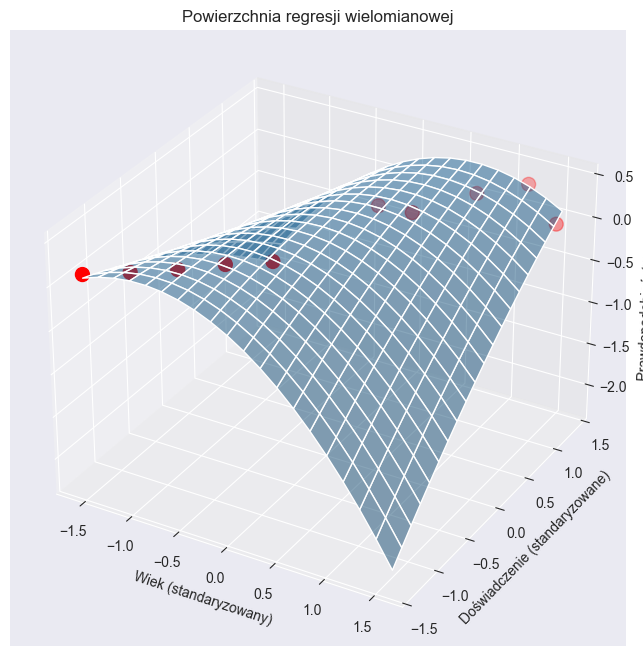

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

# Tworzymy przykładowe dane
data = {
    'age_avg': [20.5, 24.5, 28.5, 32.5, 36.5, 40.5, 44.5, 48.5, 52.5, 56.5],
    'work_experience': [1, 3, 5, 7, 9, 20, 20, 25, 28, 27],
    'success_prob': [0.100, 0.107, 0.122, 0.163, 0.180, 0.250, 0.275, 0.300, 0.330, 0.033]
}
df = pd.DataFrame(data)

# Przygotowanie danych
X = df[['age_avg', 'work_experience']]
y = df['success_prob']

# Standaryzacja zmiennych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Utworzenie cech wielomianowych
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Dopasowanie modelu
model = LinearRegression()
model.fit(X_poly, y)

# Wydruk współczynników
feature_names = ['wiek', 'doświadczenie', 'wiek²', 'wiek×doświadczenie', 'doświadczenie²']
coefficients = dict(zip(feature_names, model.coef_[1:]))

print("Równanie regresji wielomianowej:")
print(f"y = {model.intercept_:.4f}")
for name, coef in coefficients.items():
    print(f"  + {coef:.4f} × {name}")

# Wizualizacja 3D
from mpl_toolkits.mplot3d import Axes3D

# Utworzenie siatki punktów do wizualizacji
x1_grid = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 20)
x2_grid = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 20)
xx1, xx2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack((xx1.ravel(), xx2.ravel()))
X_grid_poly = poly.transform(X_grid)
y_pred_grid = model.predict(X_grid_poly)

# Wykres 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Powierzchnia predykcji
ax.plot_surface(xx1.reshape(20, 20), 
               xx2.reshape(20, 20), 
               y_pred_grid.reshape(20, 20),
               alpha=0.5)

# Rzeczywiste punkty
ax.scatter(X_scaled[:, 0], 
          X_scaled[:, 1], 
          y, 
          color='red', 
          s=100)

ax.set_xlabel('Wiek (standaryzowany)')
ax.set_ylabel('Doświadczenie (standaryzowane)')
ax.set_zlabel('Prawdopodobieństwo sukcesu')
plt.title('Powierzchnia regresji wielomianowej')
plt.show()

## Wykresiiki do danych regresji

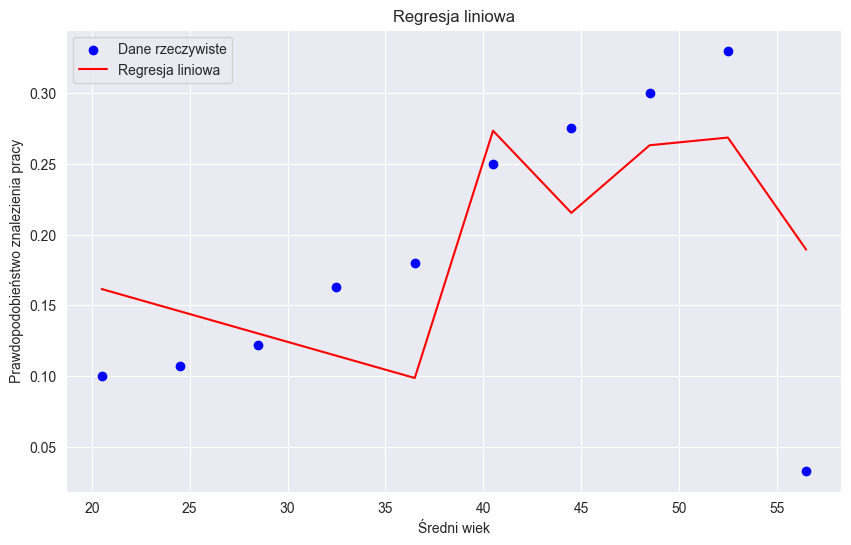

Równanie regresji liniowej:
p = 0.1860 + -0.1668*wiek_stand + 0.2118*doświadczenie_stand
R² = 0.4508


In [22]:
# Regresja liniowa
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)
y_pred_lin = lin_reg.predict(X_scaled)

# Wykres dla regresji liniowej
plt.figure(figsize=(10, 6))
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(df['age_avg'], y_pred_lin, color='red', label='Regresja liniowa')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja liniowa')
plt.legend()
plt.grid(True)
plt.show()

# Wyświetlamy równanie
print("Równanie regresji liniowej:")
print(f"p = {lin_reg.intercept_:.4f} + {lin_reg.coef_[0]:.4f}*wiek_stand + {lin_reg.coef_[1]:.4f}*doświadczenie_stand")
print(f"R² = {lin_reg.score(X_scaled, y):.4f}")

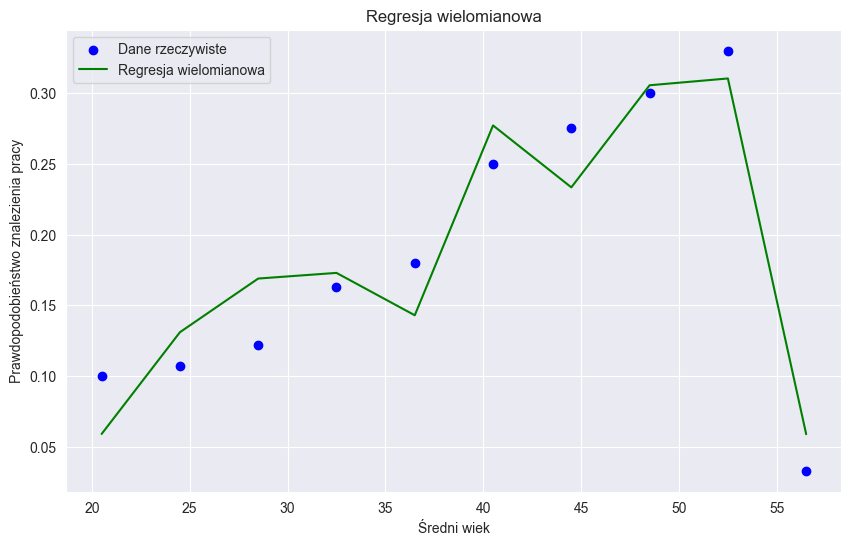


Równanie regresji wielomianowej:
p = 0.2047
  + 0.1590 × wiek
  + -0.3714 × doświadczenie
  + 0.4537 × wiek²
  + -0.0886 × wiek×doświadczenie
R² = 0.8916


In [23]:
# Regresja wielomianowa
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)

# Wykres dla regresji wielomianowej
plt.figure(figsize=(10, 6))
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(sorted(df['age_avg']), y_pred_poly[np.argsort(df['age_avg'])], 
         color='green', label='Regresja wielomianowa')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja wielomianowa')
plt.legend()
plt.grid(True)
plt.show()

# Wyświetlamy równanie
feature_names = ['wiek', 'doświadczenie', 'wiek²', 'wiek×doświadczenie', 'doświadczenie²']
print("\nRównanie regresji wielomianowej:")
print(f"p = {poly_reg.intercept_:.4f}")
for name, coef in zip(feature_names, poly_reg.coef_[1:]):
    print(f"  + {coef:.4f} × {name}")
print(f"R² = {poly_reg.score(X_poly, y):.4f}")

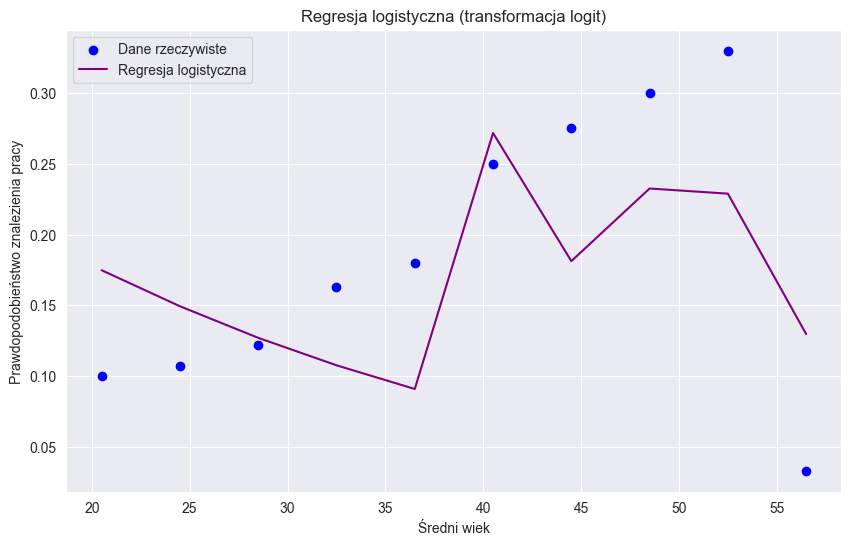


Równanie regresji logistycznej (transformacja logit):
logit(p) = -1.6446 + -1.5015*wiek_stand + 1.6744*doświadczenie_stand
gdzie p = 1 / (1 + e^(-logit(p)))
R² = 0.4077


In [24]:
# Transformacja logit
epsilon = 1e-10  # Aby uniknąć log(0)
df['logit'] = np.log((df['success_prob'] + epsilon) / (1 - df['success_prob'] + epsilon))

# Regresja z transformacją logit
logit_reg = LinearRegression()
logit_reg.fit(X_scaled, df['logit'])
y_pred_logit = 1 / (1 + np.exp(-logit_reg.predict(X_scaled)))

# Wykres dla regresji logistycznej
plt.figure(figsize=(10, 6))
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(sorted(df['age_avg']), y_pred_logit[np.argsort(df['age_avg'])], 
         color='purple', label='Regresja logistyczna')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja logistyczna (transformacja logit)')
plt.legend()
plt.grid(True)
plt.show()

# Wyświetlamy równanie
print("\nRównanie regresji logistycznej (transformacja logit):")
print(f"logit(p) = {logit_reg.intercept_:.4f} + {logit_reg.coef_[0]:.4f}*wiek_stand + {logit_reg.coef_[1]:.4f}*doświadczenie_stand")
print(f"gdzie p = 1 / (1 + e^(-logit(p)))")
print(f"R² = {r2_score(y, y_pred_logit):.4f}")

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


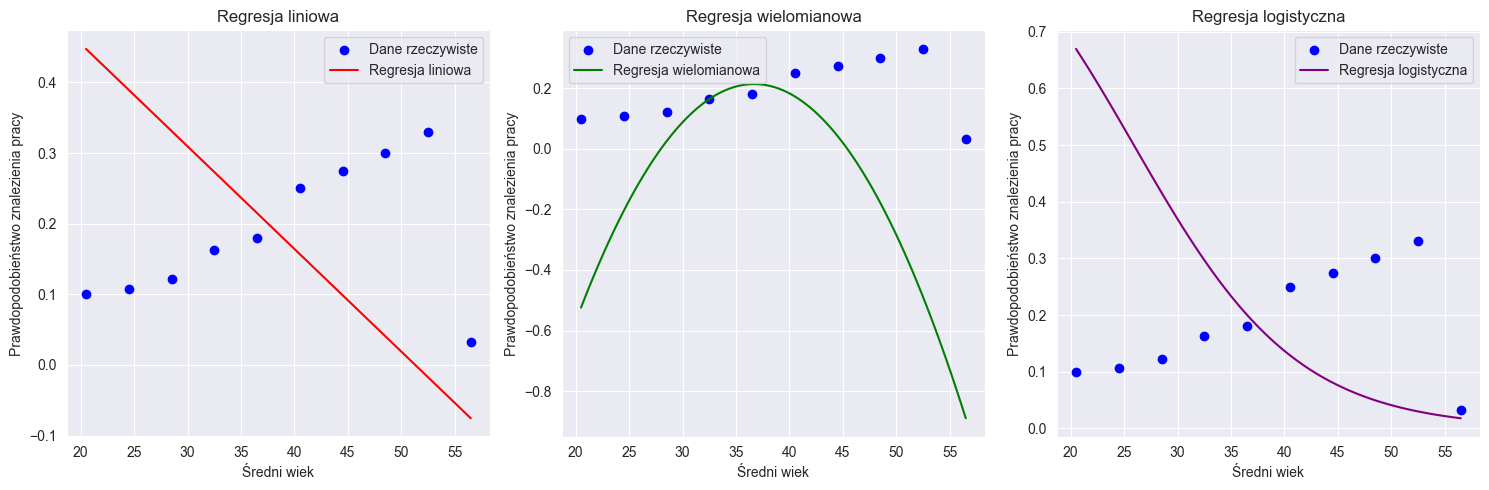

In [25]:
# Tworzymy punkty do płynnego wykresu
X_continuous = np.linspace(df['age_avg'].min(), df['age_avg'].max(), 100).reshape(-1, 1)

# Przygotowujemy dane do transformacji
X_continuous_scaled = scaler.transform(np.column_stack([X_continuous, 
                                                      np.ones_like(X_continuous) * df['work_experience'].mean()]))

# Regresja liniowa
y_pred_lin_continuous = lin_reg.predict(X_continuous_scaled)

# Regresja wielomianowa
X_poly_continuous = poly.transform(X_continuous_scaled)
y_pred_poly_continuous = poly_reg.predict(X_poly_continuous)

# Regresja logistyczna
y_pred_logit_continuous = 1 / (1 + np.exp(-logit_reg.predict(X_continuous_scaled)))

# Rysujemy wykresy
plt.figure(figsize=(15, 5))

# 1. Regresja liniowa
plt.subplot(131)
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(X_continuous, y_pred_lin_continuous, color='red', label='Regresja liniowa')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja liniowa')
plt.legend()

# 2. Regresja wielomianowa
plt.subplot(132)
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(X_continuous, y_pred_poly_continuous, color='green', label='Regresja wielomianowa')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja wielomianowa')
plt.legend()

# 3. Regresja logistyczna
plt.subplot(133)
plt.scatter(df['age_avg'], df['success_prob'], color='blue', label='Dane rzeczywiste')
plt.plot(X_continuous, y_pred_logit_continuous, color='purple', label='Regresja logistyczna')
plt.xlabel('Średni wiek')
plt.ylabel('Prawdopodobieństwo znalezienia pracy')
plt.title('Regresja logistyczna')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\szyme\PycharmProjects\Azure-db-test2\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


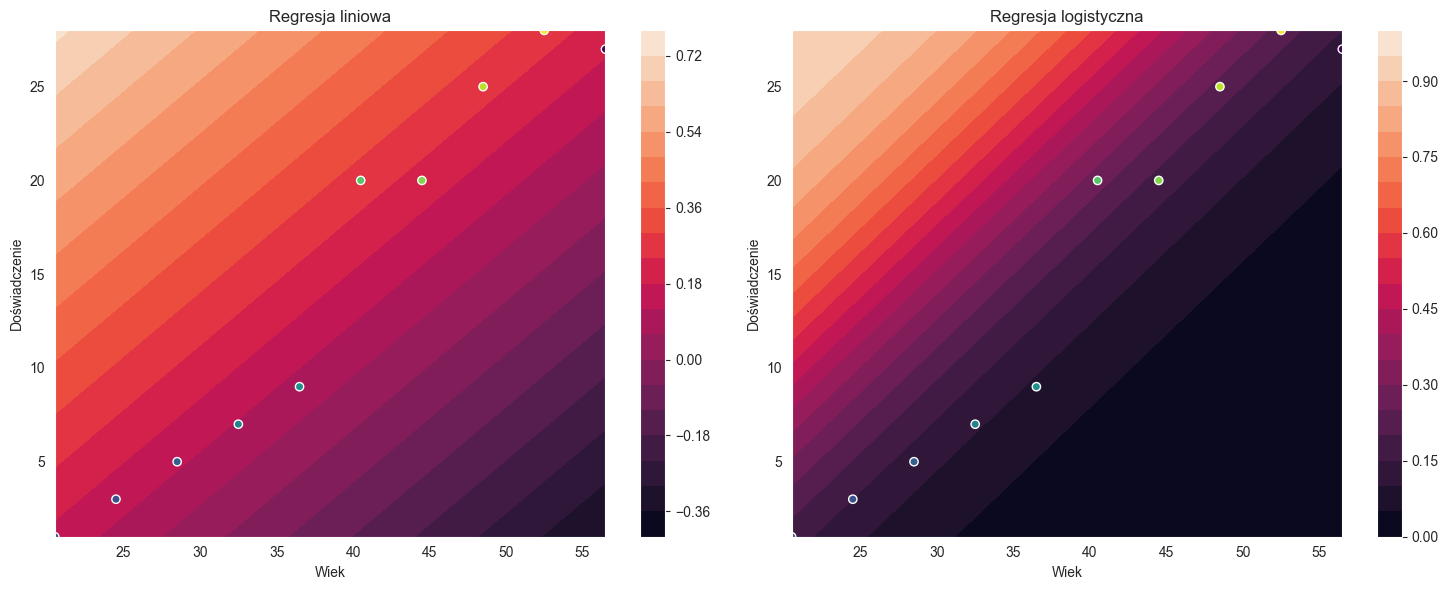

In [26]:
# Utworzenie siatki punktów
age_range = np.linspace(df['age_avg'].min(), df['age_avg'].max(), 50)
exp_range = np.linspace(df['work_experience'].min(), df['work_experience'].max(), 50)
age_grid, exp_grid = np.meshgrid(age_range, exp_range)

# Przygotowanie danych do predykcji
X_grid = np.column_stack([age_grid.ravel(), exp_grid.ravel()])
X_grid_scaled = scaler.transform(X_grid)

# Przewidywania
y_pred_lin = lin_reg.predict(X_grid_scaled)
y_pred_logit = 1 / (1 + np.exp(-logit_reg.predict(X_grid_scaled)))

# Przekształcenie wyników do siatki
y_lin_grid = y_pred_lin.reshape(age_grid.shape)
y_logit_grid = y_pred_logit.reshape(age_grid.shape)

# Wizualizacja
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Mapa ciepła dla regresji liniowej
im1 = ax1.contourf(age_grid, exp_grid, y_lin_grid, levels=20)
ax1.scatter(df['age_avg'], df['work_experience'], c=df['success_prob'], 
           cmap='viridis', edgecolor='white')
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Doświadczenie')
ax1.set_title('Regresja liniowa')
plt.colorbar(im1, ax=ax1)

# Mapa ciepła dla regresji logistycznej
im2 = ax2.contourf(age_grid, exp_grid, y_logit_grid, levels=20)
ax2.scatter(df['age_avg'], df['work_experience'], c=df['success_prob'], 
           cmap='viridis', edgecolor='white')
ax2.set_xlabel('Wiek')
ax2.set_ylabel('Doświadczenie')
ax2.set_title('Regresja logistyczna')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()